In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import pandas as pd

In [2]:
# define variables
parties = ["SPD",
          "FDP",
          "Grüne",
          "CDU",
          "CSU",
          "Linke",
          "AfD",
          "SSW"]

# Vorschlag Ampel
ampel_seats = [168, 75, 96, 124, 34, 32, 68, 1]

# Vorschlag CDU/CSU
cxu_seats = [205, 38, 64, 106, 62, 19, 50, 0]

# Farben
colors = ['#e3000f','#ffed00','#46962b','#32302e', '#0080c9', '#b61c3e', '#009ee0', '#003C8F']

party_colors = dict(zip(parties, colors))
distributions = {'aktuell': {'SPD': 206, 'FDP': 92, 'Grüne': 118, 'CDU': 152, 'CSU': 45, 'Linke': 39, 'AfD': 83, 'SSW': 1},
                'Vorschlag Ampel': {'SPD': 168, 'FDP': 75, 'Grüne': 96, 'CDU': 124, 'CSU': 34, 'Linke': 32, 'AfD': 68, 'SSW': 1},
                'Vorschlag CDU CSU': {'SPD': 205, 'FDP': 38, 'Grüne': 64, 'CDU': 160, 'CSU': 62, 'Linke': 19, 'AfD': 50, 'SSW': 0}}

def get_percent_distribution(distribution):
    percent_distribution = {}
    for k, dist in distribution.items():
        sum_seats = sum(dist.values())
        percent_distribution[k] = {k: round((v/sum_seats)*100, 2) for k, v in dist.items()}
        print(f'sanity check {k}: {round(sum(percent_distribution[k].values()), 2)}')
    return percent_distribution

percent_distributions = get_percent_distribution(distributions)

sanity check aktuell: 100.0
sanity check Vorschlag Ampel: 100.0
sanity check Vorschlag CDU CSU: 100.0


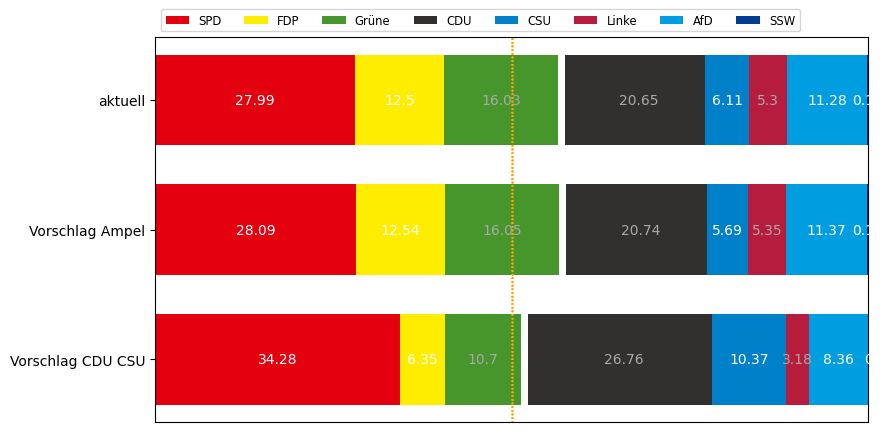

In [3]:
# stacked bar chart
def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

labels = list(distributions.keys())

data = np.array(list(list(x.values()) for x in percent_distributions.values()))
data_cum = data.cumsum(axis=1)

fig, ax = plt.subplots(figsize=(9.2, 5))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(party_colors.items()):
    
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    if i == 3: 
        starts += 1
    rects = ax.barh(labels, widths, left=starts, height=0.7,
                    label=colname, color=color)

    r, g, b = hex_to_rgb(color)
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    ax.bar_label(rects, label_type='center', color=text_color)
    # draw vertical 50% line
    ax.axvline(50, color='orange', linestyle='dotted', linewidth=1)

ax.legend(ncol=len(parties), bbox_to_anchor=(0, 1),
            loc='lower left', fontsize='small')

plt.show()

In [4]:
# Verteilungen und mögliche Koalitionen
# Paare die sich ausschließen
excludes = {
    'SPD': ['AfD'],
    'CDU': ['Linke'],
    'CSU': ['Linke'],
    'FDP': ['Linke', 'AfD'],
    'Linke': ['FDP', 'AfD'],
    'AfD': [],
    'Grüne': ['AfD'],
    'SSW': []
}
all_coalitions = {}
for k, v in percent_distributions.items():
    # group parties if sum is > 50%
    possible_coalitions = {}
    for i, (party, percent) in enumerate(v.items()):
        # add another party to coalition, if sum is < 50%        
        sum_of_coalition = percent
        coalition = party
        for j in range(i+1, len(v)):
            next = list(v.keys())[j]
            # check if any coalition party is excludes the next party
            ex = False
            parties_in_coalition = coalition.split(', ')
            for p in parties_in_coalition:
                if next in excludes.get(p):
                    ex = True
            if ex:
                continue
            sum_of_coalition += v.get(next)
            coalition += ', ' + next
            if sum_of_coalition > 50:
                possible_coalitions[coalition] = round(sum_of_coalition, 2)
                break
    all_coalitions[k] = possible_coalitions
print(all_coalitions)

# create the seat data for each coalition
coalition_seats = {}
for k, v in all_coalitions.items():
    coalition_seats[k] = {}
    for coalition, percent in v.items():
        parties_in_coalition = coalition.split(', ')
        coalition_seats[k][coalition] = [distributions[k][party] for party in parties_in_coalition]
print(coalition_seats)

{'aktuell': {'SPD, FDP, Grüne': 56.52, 'FDP, Grüne, CDU, CSU': 55.29}, 'Vorschlag Ampel': {'SPD, FDP, Grüne': 56.68, 'FDP, Grüne, CDU, CSU': 55.02}, 'Vorschlag CDU CSU': {'SPD, FDP, Grüne': 51.33, 'FDP, Grüne, CDU, CSU': 54.18}}
{'aktuell': {'SPD, FDP, Grüne': [206, 92, 118], 'FDP, Grüne, CDU, CSU': [92, 118, 152, 45]}, 'Vorschlag Ampel': {'SPD, FDP, Grüne': [168, 75, 96], 'FDP, Grüne, CDU, CSU': [75, 96, 124, 34]}, 'Vorschlag CDU CSU': {'SPD, FDP, Grüne': [205, 38, 64], 'FDP, Grüne, CDU, CSU': [38, 64, 160, 62]}}


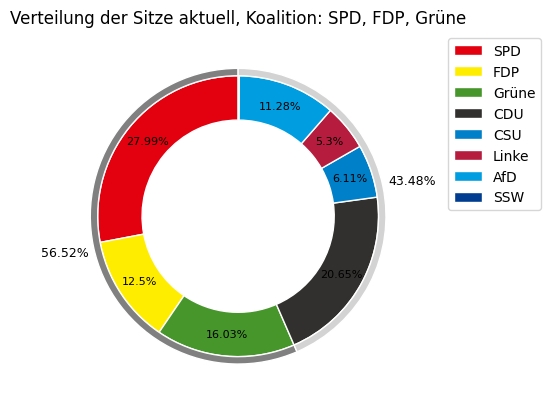

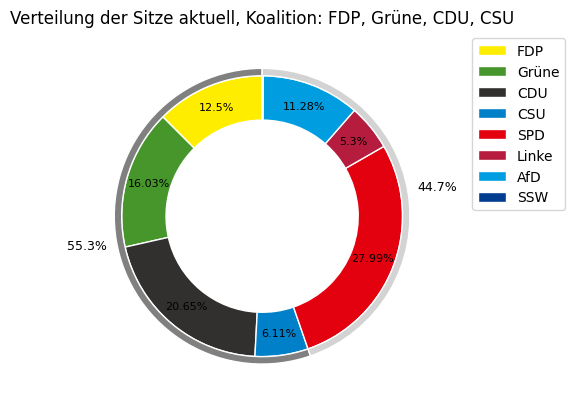

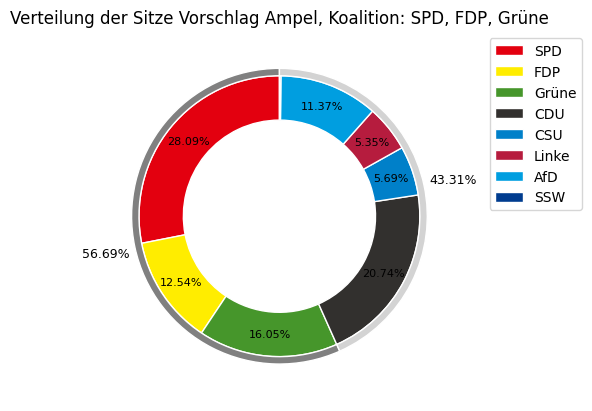

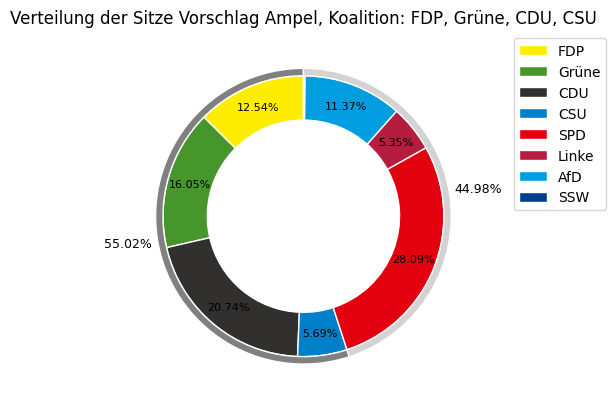

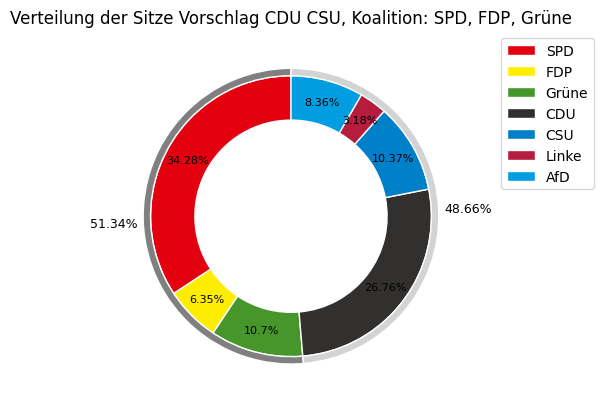

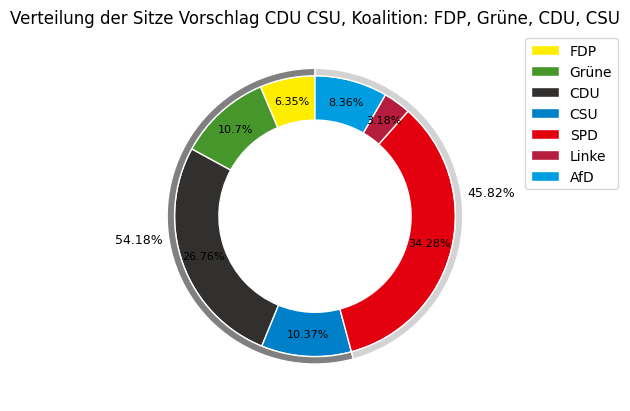

In [5]:
# nested pie chart


plots = []
for k, val in coalition_seats.items():
    for i, (coalition, seats) in enumerate(val.items()):
        # get opposition
        fig, ax = plt.subplots()
        opposition = ', '.join([x for x in parties if x not in coalition.split(', ')])
        opposition_seats = [distributions[k][x] for x in opposition.split(', ')]
        
        # get the values of the dict
        coalition_values = [x for x in seats]
        opposition_values = [x for x in opposition_seats]
        # pad values to have same length as the longest list
        coalition_values += [0] * abs((len(opposition_seats) - len(coalition_values)))
        opposition_values += [0] * abs((len(coalition_values) - len(opposition_values)))
        
        vals = np.array([coalition_values, opposition_values])
        
        # set coalition color to a lighter version of the party color as a gradient
        coalition_colors = [party_colors[x] for x in coalition.split(', ')]
        outer_colors = ['grey', 'lightgrey']
        parties_sorted = coalition + ', ' + opposition
        inner_colors = [party_colors[x] for x in parties_sorted.split(', ')]

        outer_size = 0.05
        inner_size = 0.3

        inner_vals = vals[vals!=0].flatten()
        ax.pie(inner_vals, radius=1-outer_size, colors=inner_colors,
                        wedgeprops=dict(width=inner_size, edgecolor='w'), startangle=90,
                        autopct=lambda p: f'{round(p, 2)}%' if p > 0.2 else '',
                        pctdistance=0.84, textprops=dict(color='black', fontsize=8))
        ax.legend(parties_sorted.split(', '), loc='upper left', bbox_to_anchor=(1.05, 1))

        ax.pie(x=vals.sum(axis=1), radius=1, colors=outer_colors,
                        wedgeprops=dict(width=outer_size, edgecolor='w'), startangle=90,
                        autopct=lambda p: f'{round(p, 2)}%' if p > 0.2 else '',
                        pctdistance=1.2, textprops=dict(color='black', fontsize=9))

        ax.set(aspect="equal", title=f"Verteilung der Sitze {k}, Koalition: {coalition}")
        ax.set_axis_off()
        plots.append(ax)
        plt.savefig(f'plots/{k}_{coalition}.png')

plt.show()

        